<a href="https://colab.research.google.com/github/AakankshaDhidhi/Myrepository/blob/main/Mobilenetcarobjdetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from queue import Queue
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.data import Dataset
from IPython.display import display
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_dataset_images_path = '/content/drive/MyDrive/carobjectdetection/data/training_images'
#training_dataset_images_path ='/content/drive/MyDrive/carobjectdetection/training_images'
testing_dataset_images_path = '/content/drive/MyDrive/carobjectdetection/data/testing_images'
#testing_dataset_images_path = '/content/drive/MyDrive/carobjectdetection/testing_images'

In [ ]:
#boxes_df = pd.read_csv('/content/drive/MyDrive/carobjdetect1/train_solution_bounding_boxes (1).csv')
boxes_df = pd.read_csv('/content/drive/MyDrive/carobjectdetection/data/train_solution_bounding_boxes (1).csv')
boxes_df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764800  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020261  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

In [ ]:
def single_inputs(img_arr):
    x,y,z = img_arr.shape
    return img_arr.reshape((1,x,y,z))

In [ ]:
class DetectionBox:
    def __init__(self,x_min,y_min,x_max,y_max):
        self.x_min = x_min
        self.y_min = y_min
        self.x_max = x_max
        self.y_max = y_max
    
    @staticmethod
    def from_named_tuple(tup):
        return DetectionBox(tup.xmin,tup.ymin,tup.xmax,tup.ymax)
    
    def scale(self,scale_mul):
        return DetectionBox(
            self.x_min * scale_mul,
            self.y_min * scale_mul,
            self.x_max * scale_mul,
            self.y_max * scale_mul
        )
    
    def resize_to_point(self,x,y):
        if self.x_min > x:
            self.x_min = x
        if self.x_max < x:
            self.x_max = x
        if self.y_min > y:
            self.y_min = y
        if self.y_max < y:
            self.y_max = y

class TrainingCase:
    def __init__(self,img_path):
        self.img_path = img_path
        self.boxes = []
    
    def add_box(self,tup):
        self.boxes.append(DetectionBox.from_named_tuple(tup))
    
    def get_image(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        return img_arr
    
    def draw_image_with_boxes(self):
        img = load_img(self.img_path)
        img_arr = img_to_array(img)
        h,w = img_arr.shape[:2]
        
        def point(y,x,color):
            x = int(x)
            y = int(y)
            if x >= 0 and x < w and y >= 0 and y < h:
                img_arr[y,x,:] = color
        
        for box in self.boxes:
            if box.x_min-1 >= 0:
                for y in range(int(box.y_min),int(box.y_max)):
                    point(y, box.x_min-1,(0,255,0))
                    point(y, box.x_min  ,(0,255,0))
                    point(y, box.x_min+1,(0,255,0))
                    point(y, box.x_max-1,(0,255,0))
                    point(y, box.x_max  ,(0,255,0))
                    point(y, box.x_max+1,(0,255,0))
                for x in range(int(box.x_min),int(box.x_max)):
                    point(box.y_min-1, x,(0,255,0))
                    point(box.y_min  , x,(0,255,0))
                    point(box.y_min+1, x,(0,255,0))
                    point(box.y_max-1, x,(0,255,0))
                    point(box.y_max  , x,(0,255,0))
                    point(box.y_max+1, x,(0,255,0))
        
        img = PIL.Image.fromarray(img_arr.astype(np.uint8),'RGB')
        display(img)
    
    def get_answer(self):
        img = load_img(self.img_path)
        img_w, img_h = img.size
        
        h,w = int(img_h/32),int(img_w/32)
        out_arr = np.concatenate((np.full((1,h,w,1),-1,dtype=np.float),np.ones((1,h,w,1),dtype=np.float)),axis=3)
        
        
        for box in self.boxes:
            x_min,y_min,x_max,y_max = int(box.x_min / 32),int(box.y_min / 32),int(box.x_max / 32),int(box.y_max / 32)
            for y in range(y_min,y_max):
                for x in range(x_min,x_max):
                    if y < 0 or x < 0 or y >= h or x >= w:
                        continue
                    
                    out_arr[0,y,x,0] = 1
                    out_arr[0,y,x,1] = -1
        
        return out_arr
    
    def get_answer_as_outputs(self):
        answer = self.get_answer()
        return answer[0,:,:,0],answer[0,:,:,1]
    
    def get_inputs(self):
        return single_inputs(self.get_image())

In [ ]:
class KerasModelWrapper:
    def __init__(self,model):
        self._model = model
    
    @staticmethod
    def _normalize(matrix,min_val,max_val):
        return (matrix - min_val) / (max_val - min_val)
    
    def predict(self,case):
        inputs = case.get_inputs()
        results = self._model.predict(inputs)
        
        outs1 = results[0,:,:,0]
        outs2 = results[0,:,:,1]
        
        min_val = min(outs1.min(),outs2.min())
        max_val = min(outs1.max(),outs2.max())
        
        n_outs1 = KerasModelWrapper._normalize(outs1,min_val,max_val)
        n_outs2 = KerasModelWrapper._normalize(outs2,min_val,max_val)
        
        return outs1,outs2,(n_outs1 > n_outs2)
    
    def __call__(self,case):
        return self.predict(case)

In [ ]:
def df_to_training_list(df):
    trn_dict = dict()

    for i in boxes_df.itertuples():
        if not i.image in trn_dict:
            trn_case = TrainingCase(training_dataset_images_path + '/' + i.image)
            trn_dict[i.image] = trn_case
        else:
            trn_case = trn_dict[i.image]
        trn_case.add_box(i)

    trn_list = [val for (key,val) in trn_dict.items()]

    return trn_list

In [ ]:
def draw_outputs(outputs):
    for out in outputs:
        out = out * 1 # This operation should case boolean matrix to numeric.
        min_val = out.min()
        max_val = out.max()
        out = (out - min_val) / (max_val - min_val)
        img = PIL.Image.fromarray((out*255).astype(np.uint8),'L')
        w,h = img.size
        img = img.resize((w*4,h*4))
        display(img)

In [ ]:
training_list = df_to_training_list(boxes_df)

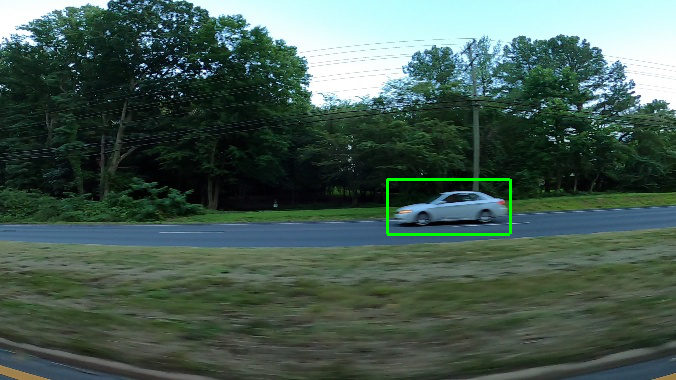

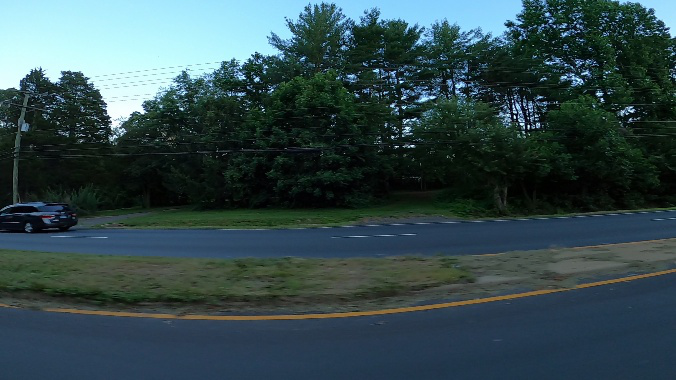

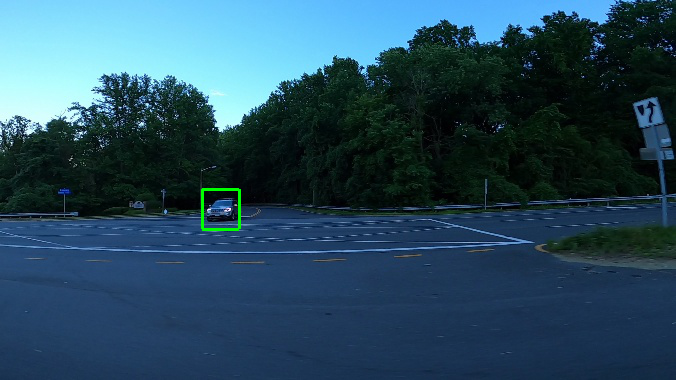

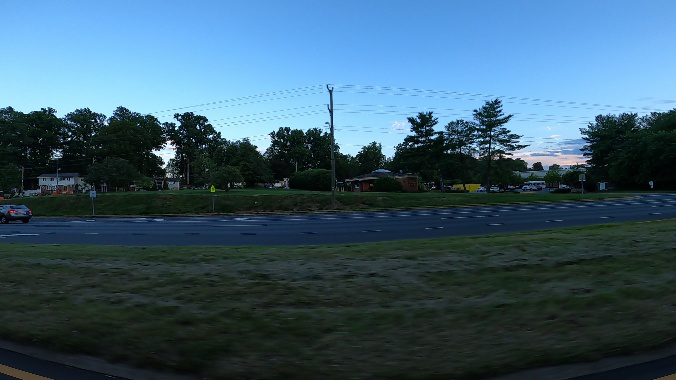

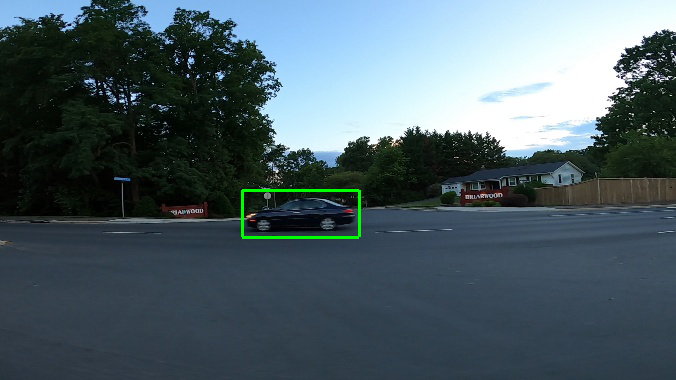

In [ ]:
for i in range(5):
    idx = random.randrange(len(training_list))
    training_list[idx].draw_image_with_boxes()

In [ ]:
train_X = np.concatenate([x.get_inputs() for x in training_list],axis=0)
train_y = np.concatenate([x.get_answer() for x in training_list],axis=0)

In [ ]:
def build_model():
    mobilenet = MobileNetV2(weights='imagenet',include_top=False)
    x = mobilenet.outputs[0]
    x = Conv2D(2,1)(x)
    model = Model(mobilenet.inputs,x)
    model.compile('adam',loss = 'mse',metrics = ['mae','mape','accuracy'])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

In [ ]:
history = model.fit(train_X,train_y,epochs = 10,batch_size=8)

Epoch 1/10
45/45 [==============================] - 34s 567ms/step - loss: 0.5534 - mae: 0.4582 - mape: 45.8178 - accuracy: 0.9371
Epoch 2/10
45/45 [==============================] - 23s 512ms/step - loss: 0.0721 - mae: 0.1787 - mape: 17.8663 - accuracy: 0.9868
Epoch 3/10
45/45 [==============================] - 23s 514ms/step - loss: 0.0466 - mae: 0.1332 - mape: 13.3170 - accuracy: 0.9904
Epoch 4/10
45/45 [==============================] - 23s 516ms/step - loss: 0.0332 - mae: 0.1074 - mape: 10.7416 - accuracy: 0.9930
Epoch 5/10
45/45 [==============================] - 23s 517ms/step - loss: 0.0231 - mae: 0.0869 - mape: 8.6869 - accuracy: 0.9954
Epoch 6/10
45/45 [==============================] - 23s 512ms/step - loss: 0.0178 - mae: 0.0771 - mape: 7.7125 - accuracy: 0.9967
Epoch 7/10
45/45 [==============================] - 23s 517ms/step - loss: 0.0137 - mae: 0.0699 - mape: 6.9926 - accuracy: 0.9978
Epoch 8/10
45/45 [==============================] - 23s 514ms/step - loss: 0.0089 - ma

In [ ]:
model.save('car_detection')

INFO:tensorflow:Assets written to: car_detection/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
!zip -r car_detection.zip car_detection
!rm -rv car_detection

  adding: car_detection/ (stored 0%)
  adding: car_detection/variables/ (stored 0%)
  adding: car_detection/variables/variables.index (deflated 80%)
  adding: car_detection/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: car_detection/assets/ (stored 0%)
  adding: car_detection/saved_model.pb (deflated 92%)
  adding: car_detection/keras_metadata.pb (deflated 95%)
removed 'car_detection/variables/variables.index'
removed 'car_detection/variables/variables.data-00000-of-00001'
removed directory 'car_detection/variables'
removed directory 'car_detection/assets'
removed 'car_detection/saved_model.pb'
removed 'car_detection/keras_metadata.pb'
removed directory 'car_detection'


In [ ]:
model_wrapper = KerasModelWrapper(model)

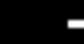

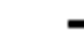

In [ ]:
random_case = training_list[random.randrange(len(training_list))]
draw_outputs(random_case.get_answer_as_outputs())

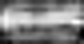

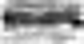

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


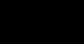

In [ ]:
draw_outputs(model_wrapper.predict(random_case))

In [ ]:
def load_test_images(path):
    cases = []
    for filename in os.listdir(path):
        file_path = path + '/' + filename
        case = TrainingCase(file_path)
        cases.append(case)
    
    return cases

In [ ]:
def populate_boxes(model,case):
    prediction = model.predict(case)
    mask = prediction[2].copy()
    h,w = mask.shape
    boxes = []
    
    def walk_on_box(sx,sy):
        box = DetectionBox(sx,sy,sx,sy)
        q = Queue()
        q.put((sx,sy))
        while not q.empty():
            x,y = q.get()
            box.resize_to_point(x+1,y+1)
            mask[y,x] = False
            if y+1 < h and mask[y+1,x]:
                q.put((x,y+1))
            if y-1 >= 0 and mask[y-1,x]:
                q.put((x,y-1))
            if x+1 < w and mask[y,x+1]:
                q.put((x+1,y))
            if x-1 >= 0 and mask[y,x-1]:
                q.put((x-1,y))
        
        return box.scale(32)
    
    for y in range(h):
        for x in range(w):
            if mask[y,x]:
                boxes.append(walk_on_box(x,y))
    
    case.boxes = boxes

In [ ]:
testing_list = load_test_images(testing_dataset_images_path)
for case in testing_list:
    populate_boxes(model_wrapper,case)

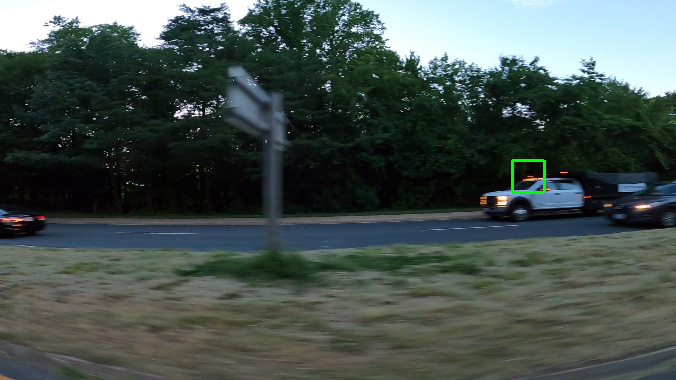

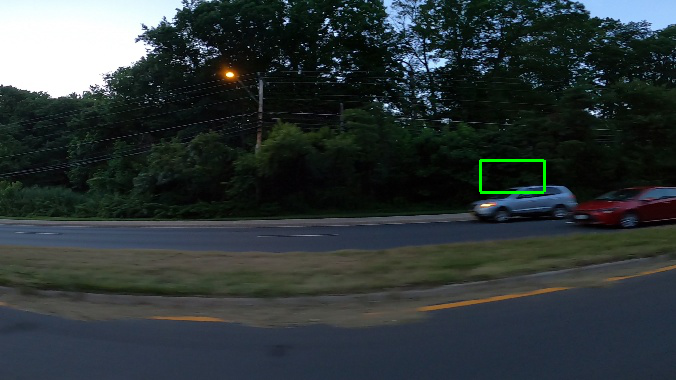

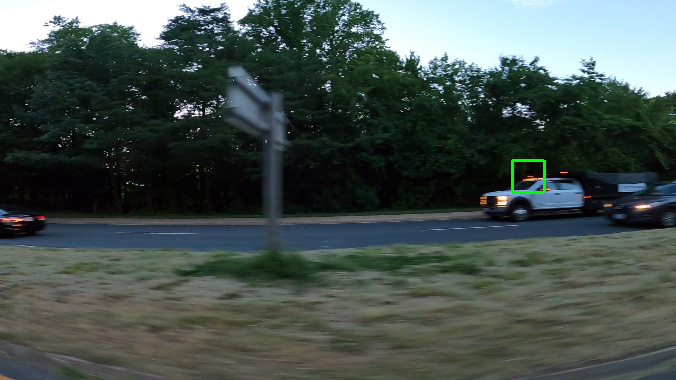

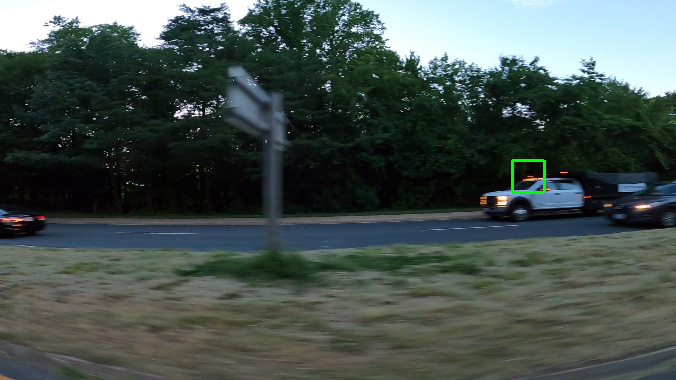

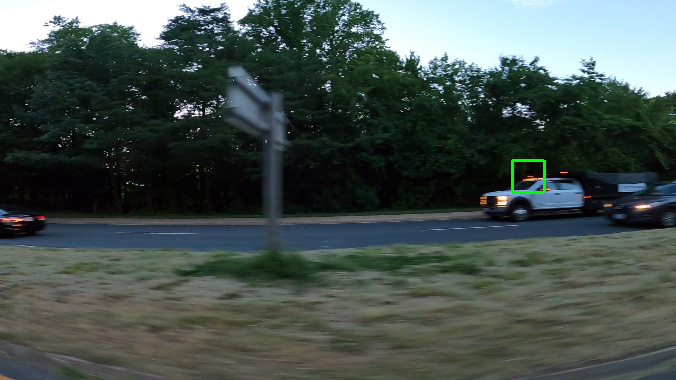

In [ ]:
for i in range(5):
    idx = random.randrange(len(testing_list))
    while len(testing_list[idx].boxes) == 0:
        idx = random.randrange(len(testing_list))
    testing_list[idx].draw_image_with_boxes()

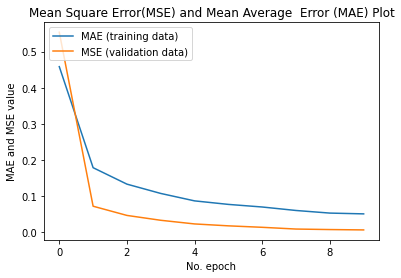

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['loss'], label='MSE (validation data)')
plt.title('Mean Square Error(MSE) and Mean Average  Error (MAE) Plot')
plt.ylabel('MAE and MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

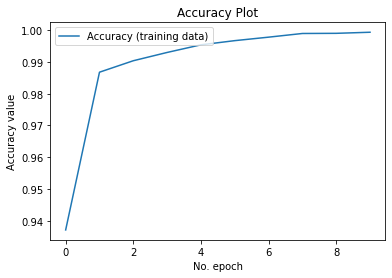

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
#plt.plot(history.history['loss'], label='MSE (validation data)')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()